## LOADING GENE EXPRESSION DATA 

### TODO 
1. Reproduce figure 4 for validation and understanding of methods
2. Save data, scripts and plots in organized way
3. Update manuscript only if needed
4. Explore SVM

```
To further optimize the performance of the models, we conducted Hyperparameter Tuning using RandomizedSearchCV. This technique involved exploring various hyperparameter combinations through k-fold cross-validation to find the optimal settings for the logistic regression and RFC models.
```


In [213]:
import pandas as pd
import numpy as np

# Manuscript data
# 1. expr -> expression matrix 
# 2. meta -> metadata 
expr = pd.read_csv("ml_input/expression_log2_counts.tsv", sep="\t")
meta = pd.read_csv("ml_input/sample_metadata.tsv", sep="\t")

expr = expr.sort_values("sample_id").reset_index(drop=True)
meta = meta.sort_values("sample_id").reset_index(drop=True)

assert all(expr["sample_id"] == meta["sample_id"])



In [212]:
print(meta.head())
print(expr.head())
print(expr.shape)

   sample_id nen_subtype grade
0  CO14-3067          PD    G3
1  SC08-3655          WD    G1
2  SC13-1136          WD    G2
3  SC13-2649          WD    G2
4  SC13-3307          PD    G3
   sample_id    CALML3     PIK3R2    IL11RA     BAMBI   PLA2G10      ETV1  \
0  CO14-3067  5.700440   4.857981  5.857981  5.169925  3.584963  5.129283   
1  SC08-3655  2.807355   9.712527  7.714246  6.672425  8.118941  4.321928   
2  SC13-1136  3.906891  10.210671  6.700440  8.807355  6.554589  6.882643   
3  SC13-2649  3.584963   8.409391  6.523562  5.087463  5.857981  3.584963   
4  SC13-3307  3.000000   8.535275  6.442943  6.108524  7.219169  7.087463   

      POLD4    NFKBIZ      SMAD2  ...    VPS33B     MRPS5     NUBP1     CNOT4  \
0  5.807355  5.554589   6.392317  ...  4.523562  5.882643  3.584963  5.247928   
1  9.998590  9.727920  10.087463  ...  7.794416  9.348728  6.569856  8.774787   
2  9.457381  8.936638  10.345405  ...  7.748193  9.756556  6.727920  9.243174   
3  8.339850  8.129283   8.2

In [168]:
from sklearn.preprocessing import LabelEncoder
X = expr.drop(columns=["sample_id"]).values
y = meta["nen_subtype"].values
gene_names = expr.drop(columns=['sample_id']).columns.to_list()

le = LabelEncoder() 
y_enc = le.fit_transform(y)

y_enc = np.where(y == "PD", 1, 0)
print(le.classes_)
# Encode labels: WD = 0, PD = 1
# array(['PD', 'WD']) OR ['WD','PD'] depending on order


['PD' 'WD']


## Logistic Regression Model


In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score


lr = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=500,
    class_weight="balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

roc_scores = cross_val_score(
    lr,
    X,
    y_enc,
    cv=cv,
    scoring="roc_auc"
)

roc_scores, roc_scores.mean()



(array([1.        , 0.83333333, 1.        , 1.        , 1.        ]),
 np.float64(0.9666666666666666))

In [190]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_prob = cross_val_predict(
    lr,
    X,
    y_enc,
    cv=cv,
    method="predict_proba"
)[:, 1]

fpr, tpr, _ = roc_curve(y_enc, y_prob)
roc_auc = auc(fpr, tpr)


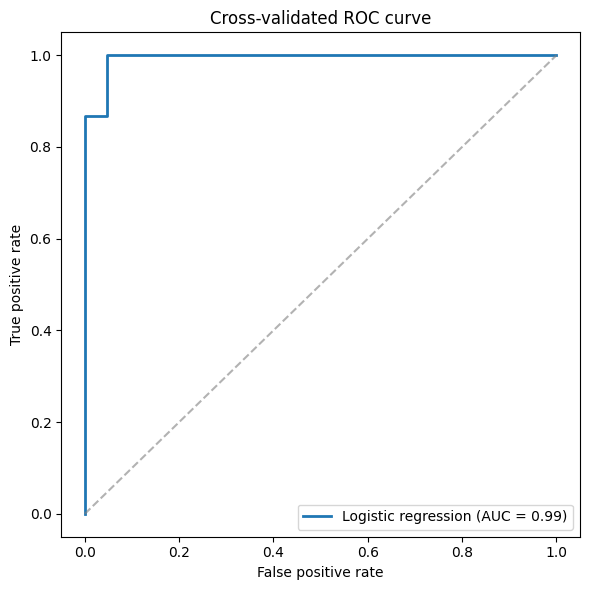

In [191]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f"Logistic regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.6)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Cross-validated ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


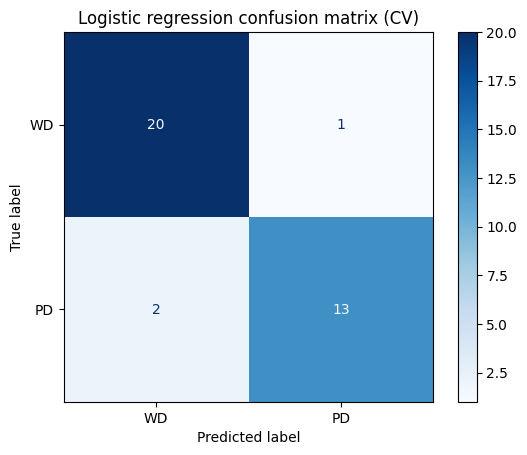

In [192]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_enc, y_pred)


disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["WD", "PD"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Logistic regression confusion matrix (CV)")
plt.show()


In [193]:
lr.fit(X, y_enc)
coef = lr.coef_[0]

coef_df = (
    pd.DataFrame({
        "gene": gene_names,
        "beta": coef
    })
    .query("beta != 0")
    .sort_values("beta")
)

# split directions 
coef_df["direction"] = np.where(
    coef_df["beta"] > 0, "PD_up", "WD_up"
)


top_n = 15
plot_df = pd.concat([
    coef_df.head(top_n),
    coef_df.tail(top_n)
])


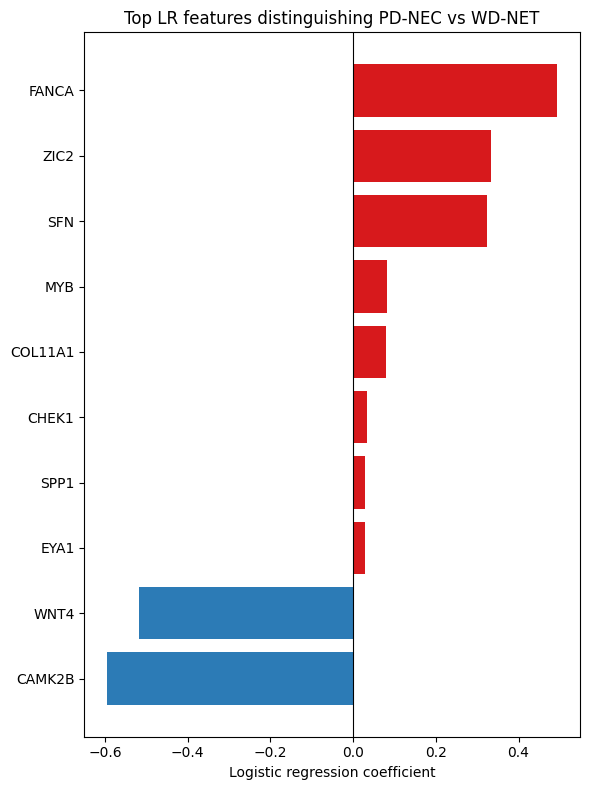

In [194]:
plt.figure(figsize=(6, 8))
plt.barh(
    plot_df["gene"],
    plot_df["beta"],
    color=plot_df["direction"].map({"PD_up": "#D7191C", "WD_up": "#2C7BB6"})
)
plt.axvline(0, color="black", lw=0.8)
plt.xlabel("Logistic regression coefficient")
plt.title("Top LR features distinguishing PD-NEC vs WD-NET")
plt.tight_layout()
plt.show()


In [175]:
from sklearn.model_selection import StratifiedKFold
coefs = []

for train_idx, test_idx in cv.split(X, y_enc):
    lr.fit(X[train_idx], y_enc[train_idx])
    coefs.append(lr.coef_[0])

coef_mat = np.vstack(coefs)

coef_stability = pd.DataFrame(
    coef_mat,
    columns=gene_names
).std().sort_values()


print(coef_stability)


CASP7       0.000470
CC2D1B      0.000517
ALKBH3      0.000587
XRCC4       0.000833
RASAL1      0.000839
              ...   
LAMC2       0.017612
CACNA2D2    0.017896
LRP2        0.018211
PCK1        0.018858
BMPR1B      0.019643
Length: 784, dtype: float64


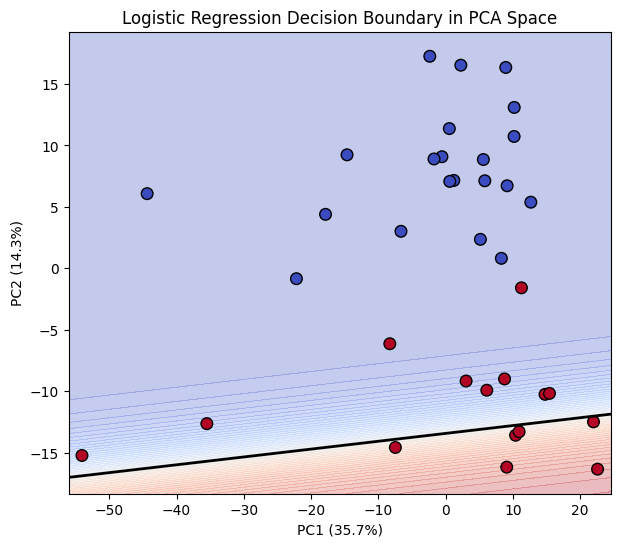

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)
pca_df["label"] = y

lr = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    max_iter=2000
)

lr.fit(X_scaled, y_enc)



xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-2, X_pca[:,0].max()+2, 200),
    np.linspace(X_pca[:,1].min()-2, X_pca[:,1].max()+2, 200)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]



grid_original = scaler.inverse_transform(
    pca.inverse_transform(grid_pca)
)


probs = lr.predict_proba(grid_original)[:, 1]
probs = probs.reshape(xx.shape)


plt.figure(figsize=(7,6))

plt.contourf(xx, yy, probs, levels=50, cmap="coolwarm", alpha=0.3)
plt.contour(xx, yy, probs, levels=[0.5], colors="black", linewidths=2)

plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=y_enc,
    cmap="coolwarm",
    edgecolor="black",
    s=70
)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Logistic Regression Decision Boundary in PCA Space")

plt.show()



In [196]:
from sklearn.ensemble import RandomForestClassifier

X = expr.drop(columns=["sample_id"]).values
y = meta["nen_subtype"].values
gene_names = expr.drop(columns=["sample_id"]).columns.to_list()

rf = RandomForestClassifier(
    n_estimators=1000,
    max_features="sqrt",
    oob_score=True,
    class_weight="balanced",
    random_state=23
)

rf.fit(X, y_enc)
rf.oob_score_


0.9444444444444444

In [197]:
import pandas as pd

rf_imp = pd.DataFrame({
    "gene": gene_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

rf_imp.head(20)
rf_imp.to_csv("data/rf_feature_importance.csv", index=False)


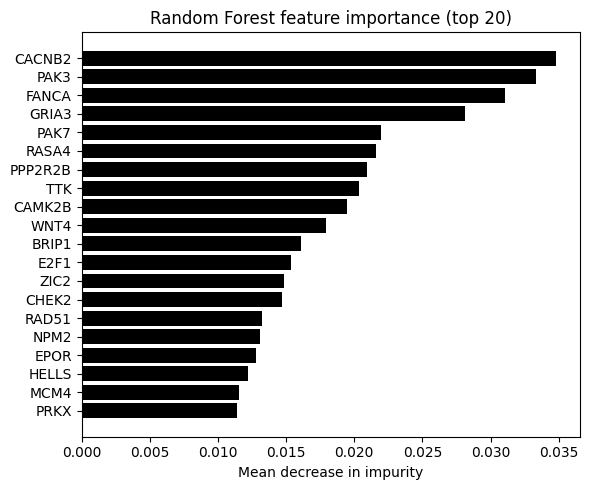

In [198]:
import matplotlib.pyplot as plt

top_n = 20

plt.figure(figsize=(6, 5))
plt.barh(
    rf_imp["gene"].head(top_n)[::-1],
    rf_imp["importance"].head(top_n)[::-1],
    color="black"
)
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest feature importance (top 20)")
plt.tight_layout()
plt.show()


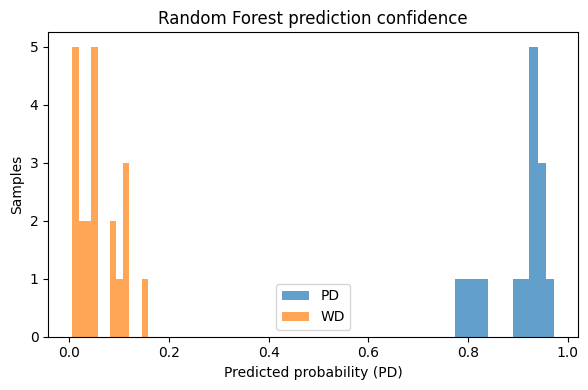

In [199]:
import numpy as np

probs = rf.predict_proba(X)[:, 1]  # PD probability

plt.figure(figsize=(6, 4))
plt.hist(probs[y_enc == 1], bins=12, alpha=0.7, label="PD") # color orange 
plt.hist(probs[y_enc == 0], bins=12, alpha=0.7, label="WD") # color blue
plt.xlabel("Predicted probability (PD)")
plt.ylabel("Samples")
plt.legend()
plt.title("Random Forest prediction confidence")
plt.tight_layout()
plt.show()


In [200]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_enc,
    test_size=0.25,
    stratify=y_enc,
    random_state=23
)


In [201]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    max_iter=500
)

lr.fit(X_train, y_train)


,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,500
,multi_class,'deprecated'


In [202]:
y_train_prob = lr.predict_proba(X_train)[:, 1]
y_test_prob  = lr.predict_proba(X_test)[:, 1]

fpr_tr_lr, tpr_tr_lr, _ = roc_curve(y_train, y_train_prob)
fpr_te_lr, tpr_te_lr, _ = roc_curve(y_test, y_test_prob)

auc_tr_lr = auc(fpr_tr_lr, tpr_tr_lr)
auc_te_lr = auc(fpr_te_lr, tpr_te_lr)



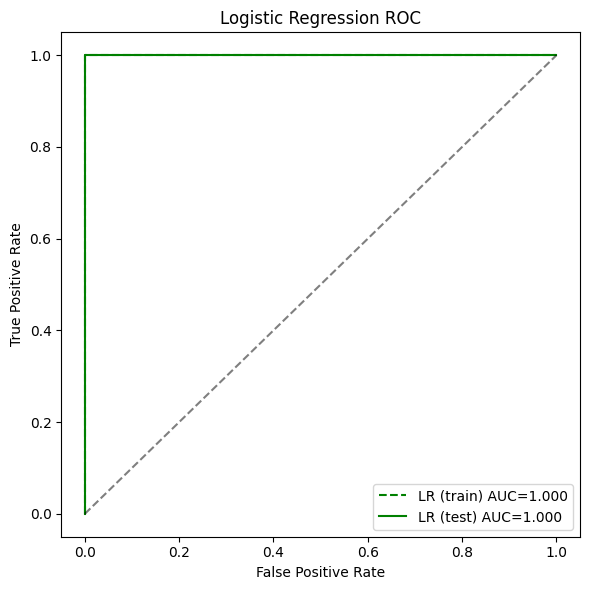

In [203]:
plt.figure(figsize=(6,6))
plt.plot(fpr_tr_lr, tpr_tr_lr, linestyle="--", color="green",
         label=f"LR (train) AUC={auc_tr_lr:.3f}")
plt.plot(fpr_te_lr, tpr_te_lr, color="green",
         label=f"LR (test) AUC={auc_te_lr:.3f}")
plt.plot([0,1],[0,1],'k--',alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC")
plt.legend()
plt.tight_layout()
plt.show()


In [204]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=1000,
    max_features="sqrt",
    class_weight="balanced",
    random_state=23
)

rf.fit(X_train, y_train)


,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [205]:
y_train_prob = rf.predict_proba(X_train)[:, 1]
y_test_prob  = rf.predict_proba(X_test)[:, 1]

fpr_tr_rf, tpr_tr_rf, _ = roc_curve(y_train, y_train_prob)
fpr_te_rf, tpr_te_rf, _ = roc_curve(y_test, y_test_prob)

auc_tr_rf = auc(fpr_tr_rf, tpr_tr_rf)
auc_te_rf = auc(fpr_te_rf, tpr_te_rf)



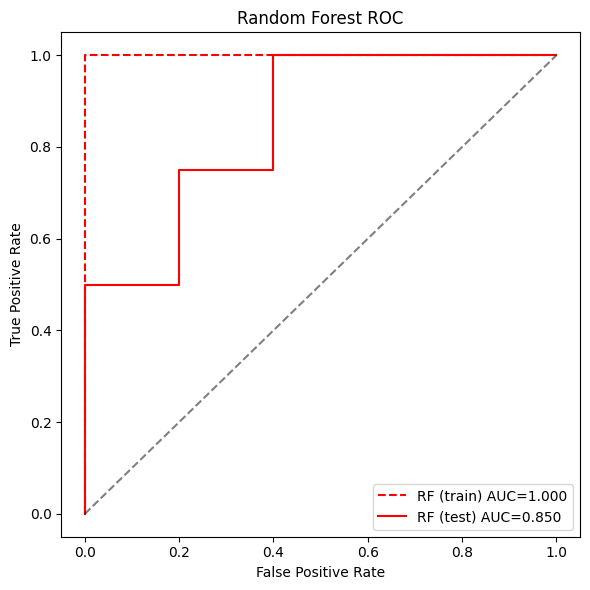

In [206]:
plt.figure(figsize=(6,6))
plt.plot(fpr_tr_rf, tpr_tr_rf, linestyle="--", color="red",
         label=f"RF (train) AUC={auc_tr_rf:.3f}")
plt.plot(fpr_te_rf, tpr_te_rf, color="red",
         label=f"RF (test) AUC={auc_te_rf:.3f}")
plt.plot([0,1],[0,1],'k--',alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC")
plt.legend()
plt.tight_layout()
plt.show()


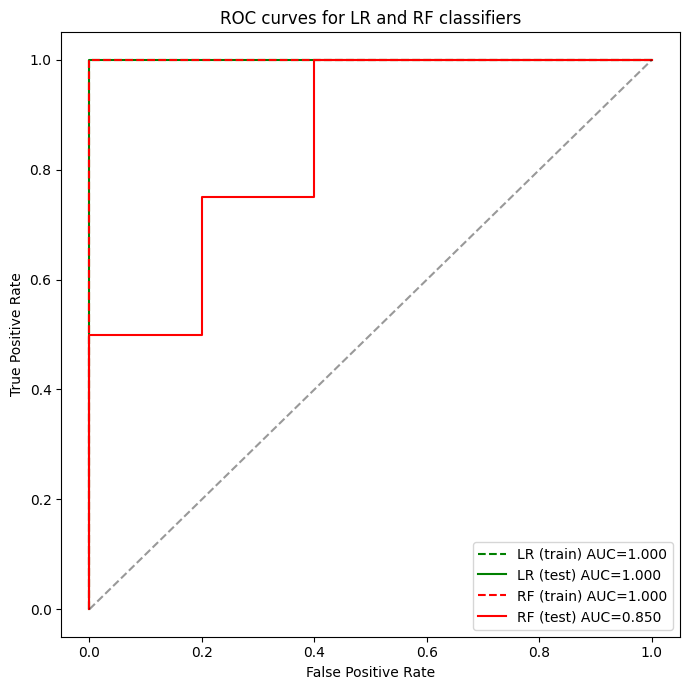

In [207]:
plt.figure(figsize=(7,7))

# LR
plt.plot(fpr_tr_lr, tpr_tr_lr, '--', color='green',
         label=f"LR (train) AUC={auc_tr_lr:.3f}")
plt.plot(fpr_te_lr, tpr_te_lr, color='green',
         label=f"LR (test) AUC={auc_te_lr:.3f}")

# RF
plt.plot(fpr_tr_rf, tpr_tr_rf, '--', color='red',
         label=f"RF (train) AUC={auc_tr_rf:.3f}")
plt.plot(fpr_te_rf, tpr_te_rf, color='red',
         label=f"RF (test) AUC={auc_te_rf:.3f}")

plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for LR and RF classifiers")
plt.legend()
plt.tight_layout()
plt.show()


In [208]:

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline


svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", LinearSVC(
        C=0.01,                  # strong regularization
        class_weight="balanced",
        max_iter=5000,
        random_state=23
    ))
])


In [209]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

svm_auc = cross_val_score(
    svm,
    X,
    y_enc,
    cv=cv,
    scoring="roc_auc"
)

svm_auc, svm_auc.mean()


(array([1., 1., 1., 1., 1.]), np.float64(1.0))

In [139]:
svm.fit(X, y_enc)


,steps,"[('scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001


In [140]:
coef = svm.named_steps["svc"].coef_.ravel()

svm_coef_df = (
    pd.DataFrame({
        "gene": gene_names,
        "coef": coef,
        "abs_coef": np.abs(coef)
    })
    .sort_values("abs_coef", ascending=False)
)


In [142]:
merged = (
    lr_coef_df
    .merge(svm_coef_df, on="gene", suffixes=("_lr", "_svm"))
)

merged[["gene", "beta", "coef"]].head(15)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,0.01
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


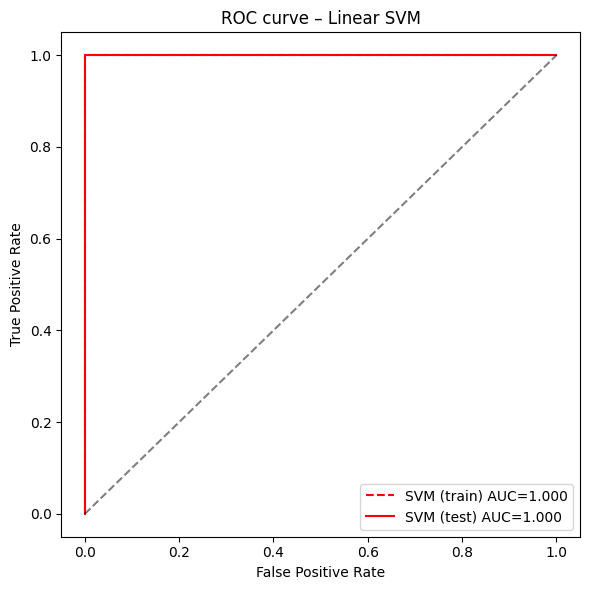

In [148]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.50, stratify=y_enc, random_state=23
)


svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", LinearSVC(
        C=0.11,
        class_weight="balanced",
        max_iter=5000,
        random_state=23
    ))
])

svm.fit(X_train, y_train)



y_train_score = svm.decision_function(X_train)
y_test_score  = svm.decision_function(X_test)

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_score)
fpr_te, tpr_te, _ = roc_curve(y_test,  y_test_score)

auc_tr = auc(fpr_tr, tpr_tr)
auc_te = auc(fpr_te, tpr_te)



plt.figure(figsize=(6,6))

plt.plot(fpr_tr, tpr_tr, '--', color='red',
         label=f"SVM (train) AUC={auc_tr:.3f}")
plt.plot(fpr_te, tpr_te, '-', color='red',
         label=f"SVM (test) AUC={auc_te:.3f}")

plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – Linear SVM")
plt.legend()
plt.tight_layout()
plt.show()




In [150]:
from sklearn.decomposition import PCA
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_scaled)
svm_2d = LinearSVC(
    C=0.01,
    class_weight="balanced",
    max_iter=5000,
    random_state=23
)

svm_2d.fit(X_pca, y_enc)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,0.01
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,23


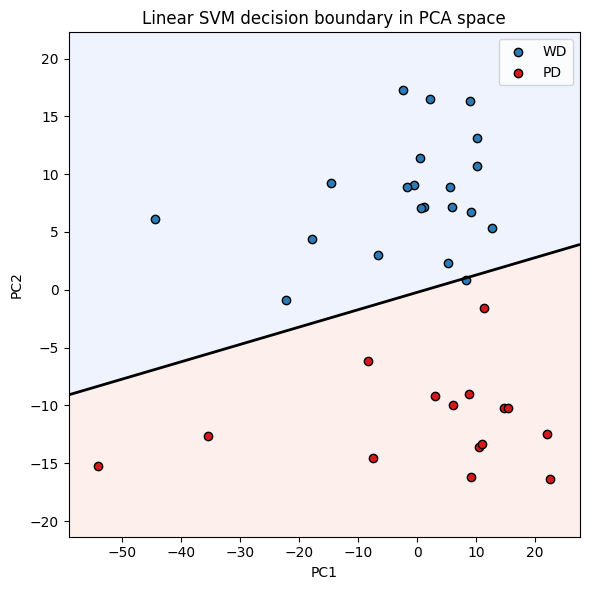

In [152]:
xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-5, X_pca[:,0].max()+5, 300),
    np.linspace(X_pca[:,1].min()-5, X_pca[:,1].max()+5, 300)
)

Z = svm_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(6,6))

plt.contourf(xx, yy, Z > 0, alpha=0.15, cmap="coolwarm")
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

plt.scatter(
    X_pca[y_enc==0,0], X_pca[y_enc==0,1],
    c="#2C7BB6", label="WD", edgecolor="k"
)
plt.scatter(
    X_pca[y_enc==1,0], X_pca[y_enc==1,1],
    c="#D7191C", label="PD", edgecolor="k"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Linear SVM decision boundary in PCA space")
plt.legend()
plt.tight_layout()
plt.show()


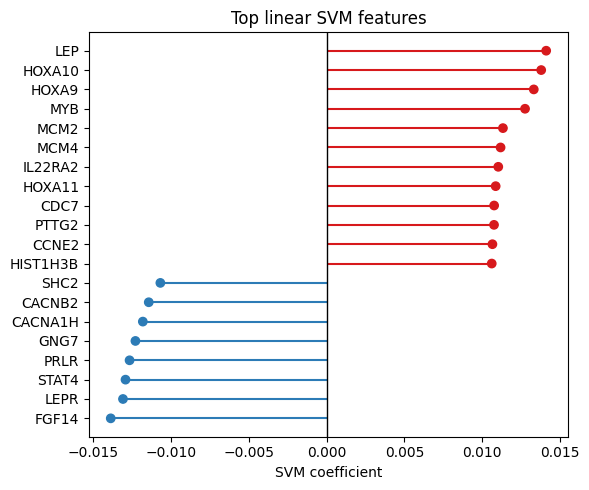

In [153]:
coef = svm.named_steps["svc"].coef_.ravel()

svm_coef_df = (
    pd.DataFrame({
        "gene": gene_names,
        "coef": coef,
        "abs_coef": np.abs(coef)
    })
    .sort_values("abs_coef", ascending=False)
)
svm_coef_df.head(15)

top = svm_coef_df.head(20).sort_values("coef")

plt.figure(figsize=(6,5))
plt.hlines(
    y=top["gene"],
    xmin=0,
    xmax=top["coef"],
    color=["#D7191C" if c>0 else "#2C7BB6" for c in top["coef"]]
)
plt.scatter(top["coef"], top["gene"],
            color=["#D7191C" if c>0 else "#2C7BB6" for c in top["coef"]])

plt.axvline(0, color="black", lw=1)
plt.xlabel("SVM coefficient")
plt.title("Top linear SVM features")
plt.tight_layout()
plt.show()



In [154]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

coef_mat = []

for train_idx, test_idx in cv.split(X, y_enc):
    svm_cv = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", LinearSVC(C=0.01, class_weight="balanced", max_iter=5000))
    ])
    svm_cv.fit(X[train_idx], y_enc[train_idx])
    coef_mat.append(svm_cv.named_steps["svc"].coef_.ravel())

coef_mat = np.vstack(coef_mat)


coef_var = np.var(coef_mat, axis=0)

stab_df = (
    pd.DataFrame({
        "gene": gene_names,
        "coef_var": coef_var,
        "mean_abs_coef": np.mean(np.abs(coef_mat), axis=0)
    })
    .sort_values("mean_abs_coef", ascending=False)
)

stab_df.head(10)


,gene,coef_var,mean_abs_coef
162,PAK3,2.175057e-06,0.014113
129,WNT4,2.154903e-06,0.013409
116,CACNB2,1.115351e-06,0.013001
422,CAMK2B,2.749971e-06,0.012719
697,PAK7,1.384210e-06,0.012572
711,CALML6,4.793366e-06,0.012340
49,RASA4,2.252844e-06,0.011205
108,LEP,9.097494e-06,0.011081
527,CXXC4,7.239297e-07,0.011010
606,DTX3,2.835597e-06,0.010984
